# Assignment 2c Notebook: Competitive Co-Evolution of Pac-Man Controllers and Ghost Controllers
For the final assignment in this course, you will use your cumulative understanding and implementation of genetic programming (GP) to implement the competitive co-evolution of Pac-Man controllers and Ghost controllers! From your previous assignment implementations, copy over the following files:
* base_evolution.py
* fitness.py
* genetic_programming.py (Note: if you haven't already, rename GeneticProgrammingPopulating -> GeneticProgrammingPopulation)
* gpac_population_evaluation.py
* selection.py
* tree_genotype.py

As usual, be careful not to overwrite any of the provided files that may have been modified since previous assignments. To begin the assignment, execute the following cell. **If you implemented your genotype in a new file, be sure to import it in the next cell!**

In [10]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from snake_eyes import read_config
from fitness import play_GPac
from selection import *
from genetic_programming import *
from tree_genotype import *
from gpac_population_evaluation import *
from parse_tree import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print('The first cell has been executed!')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The first cell has been executed!


## Ghost Controllers
Assuming you already have a working implementation of a GP algorithm for Pac-Man controllers, implementing Ghost controllers should be relatively easy. The only real difference is that, for Ghosts, the G sensor returns the distance to the nearest *other* Ghost, and there is an additional M sensor returning the distance to Pac-Man (or the nearest Pac-Man, if attempting a deliverable with multiple Pac-Man agents in the game). While the algorithms you used to create, reproduce, and evaluate Pac-Man trees should still be applicable here, you need to make sure your code can cleanly handle the different sensor sets. There are many different ways to accomplish that, and it is up to you to choose how.

## Multi-Population Fitness Evaluation
Competitive fitness in GPac has the quirk of only being relative to encountered opponents. Since opponents belong to populations that are evolving, we must re-calculate fitness for all individuals at each generation. Additionally, since it is impracticable to play against all opponents, it is necessary to *approximate* fitness in some way. In practice, you would approximate fitness of an individual through competition with a sample of opponents. In this assignment, however, we allow for each individual to play against only a single opponent per generation to manage computational cost.

**Note**: as mentioned in the assignment description, an individual from a population may have to play multiple games if co-evolving populations are not the same size. See the assignment description for more details.

As a result of the complex nature of competitive fitness for games like GPac, you will typically perform more fitness evaluations per generation than evolution using the same parameters on a problem with an objective/absolute fitness metric. For this assignment, the first generation will require $max(\mu_{PacMan}, \mu_{Ghost})$ fitness evaluations and each subsequent generation will require $max(\mu_{PacMan}+\lambda_{PacMan}, \mu_{Ghost}+\lambda_{Ghost})$ fitness evaluations.

In `gpac_population_evaluation.py`, implement the `competitive_population_evaluation` function that accepts multiple populations as inputs, forms competition match-ups of individuals from the input populations, performs fitness evaluations with the match-ups, and assigns the appropriate fitness values to individuals from the input populations. 

**Note**: the `play_GPac` function returns game score, but Ghost fitness is negated game score plus remaining time (can be found in the last entry in the game log). Recall also that each GP tree should also receive a parsimony penalty.

### Test competive_population_evaluation

In [2]:
# read config
config = read_config('./configs/green2c_config.txt', globalVars=globals(), localVars=locals())

# initialize population
random_pac_population = TreeGenotype.initialization(25, **config['initialization_kwargs'])
random_ghost_population = TreeGenotype.initialization(5, **config['initialization_kwargs'])

competitive_population_evaluation(random_pac_population, random_ghost_population, **config['fitness_kwargs'])

([<tree_genotype.TreeGenotype at 0x7f7ed0b82d30>,
  <tree_genotype.TreeGenotype at 0x7f7ee0e8a100>])

## Competitive Co-Evolution
Below is a high-level diagram of a 2-population competitive co-evolutionary algorithm. Using your Pac-Man controllers, Ghost controllers, and the `competitive_population_evaluation` function you just implemented, you should have all the necessary components to implement competitive co-evolution!
**Note**: there's a typo in the below figure and both cycles should perform whole-population Competitive Fitness Evaluation instead of evaluating only the children.
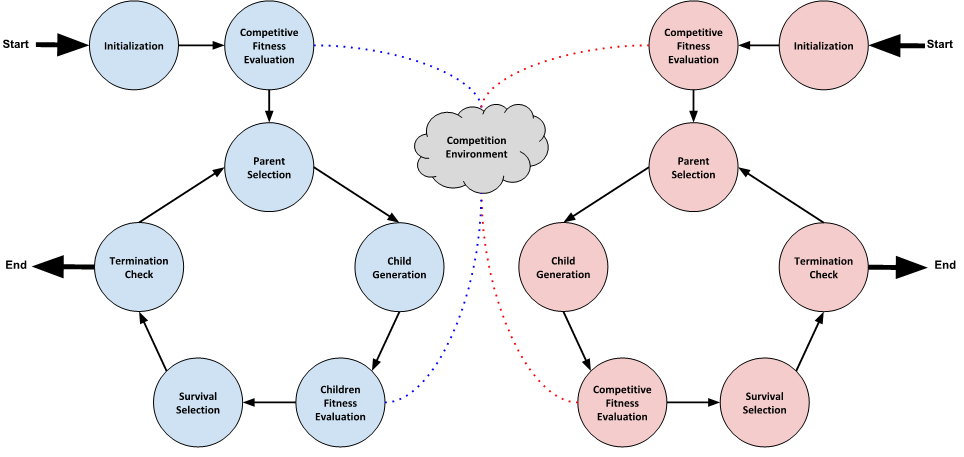

As mentioned previously, the quirks of competitive fitness require that you modify your typical evolution cycles slightly. Namely, you must re-evaluate and recalculate fitness for both populations at each generation. This means that children will be added to the population following child generation and then the *entire* population should be evaluated. Consequently, the number of fitness evaluations per generation varies from previous assignments since individuals from the previous generation are re-evaluated.

### Single Run Experiment
Now that we've covered the quirks of co-evolution a couple times, it's time for you to apply your understanding! In the following cell, implement a single 2,000-fitness-evaluation run of your competitive co-evolutionary algorithm. The config file for co-evolution is a little more complex than previous assignments, so we'll give some code to extract per-species parameters.

In [3]:
from math import inf
import statistics

# implement your EA here
def competitive_genetic_programming_search(number_evaluations, config_filename):
    config = read_config(config_filename, globalVars=globals(), localVars=locals())
    pac_config = {key.partition('_')[-1]:config[key] for key in config if "pac_" in key}
    ghost_config = {key.partition('_')[-1]:config[key] for key in config if "ghost_" in key}
    
    final_pac_fitness = -inf
    final_pac_individual = None
    
    final_ghost_fitness = -inf
    final_ghost_individual = None

    pac_data = []
    ghost_data = []
    
    # Parse the config and implement your EA here.
    # Feel free to focus on implementation first and then return for data collection.


    # full initialization of pac population
    pac_EA = GeneticProgrammingPopulation(**pac_config['EA_configs'], **pac_config, **config)
    ghost_EA = GeneticProgrammingPopulation(**ghost_config['EA_configs'], **ghost_config, **config)
    competitive_population_evaluation(pac_EA.population, ghost_EA.population, **config['fitness_kwargs'])
    pac_EA.evaluations = len(pac_EA.population)
    ghost_EA.evaluations = len(ghost_EA.population)
    
    total_evaluations = pac_EA.evaluations + ghost_EA.evaluations
    
    pac_fitnesses = [individual.fitness for individual in pac_EA.population]
    ghost_fitnesses = [individual.fitness for individual in ghost_EA.population]
    
    pac_data.append([pac_EA.evaluations, statistics.mean(pac_fitnesses), max(pac_fitnesses)])
    ghost_data.append([ghost_EA.evaluations, statistics.mean(ghost_fitnesses), max(ghost_fitnesses)])
    
    while not(total_evaluations >= number_evaluations):
        pac_children = pac_EA.generate_children()
        pac_EA.population += pac_children
        
        ghost_children = ghost_EA.generate_children()
        ghost_EA.population += ghost_children
        
        competitive_population_evaluation(pac_EA.population, ghost_EA.population, **config['fitness_kwargs'])
        
        pac_EA.evaluations += len(pac_EA.population)
        ghost_EA.evaluations += len(ghost_EA.population)
        
        total_evaluations = pac_EA.evaluations + ghost_EA.evaluations
        
        pac_fitnesses = [individual.raw_fitness for individual in pac_EA.population]
        ghost_fitnesses = [individual.raw_fitness for individual in ghost_EA.population]
        
        pac_data.append([pac_EA.evaluations, statistics.mean(pac_fitnesses), max(pac_fitnesses)])
        ghost_data.append([ghost_EA.evaluations, statistics.mean(ghost_fitnesses), max(ghost_fitnesses)])
        
        final_pac_fitness = max(pac_fitnesses)
        final_pac_individual = pac_EA.population[pac_fitnesses.index(final_pac_fitness)]
        
            
        final_ghost_fitness = max(ghost_fitnesses)
        final_ghost_individual = ghost_EA.population[ghost_fitnesses.index(final_ghost_fitness)]
        
    pacFitnessStdev = round(statistics.stdev([data[2] for data in pac_data]), 2)
    pacAverageFitness = round(statistics.mean([data[2] for data in pac_data]), 2)
    
    ghostFitnessStdev = round(statistics.stdev([data[2] for data in ghost_data]), 2)
    ghostAverageFitness = round(statistics.mean([data[2] for data in ghost_data]), 2)
    
    
    return final_pac_fitness, final_ghost_fitness, final_pac_individual, final_ghost_individual, pac_data, ghost_data, pacFitnessStdev, pacAverageFitness, ghostFitnessStdev, ghostAverageFitness

In [31]:
# Test your implementation
print(competitive_genetic_programming_search(2000, './configs/green2c_config.txt'))

(63, 1062, <tree_genotype.TreeGenotype object at 0x7fa095417910>, <tree_genotype.TreeGenotype object at 0x7fa0950f3d30>, [[50, -828.52, 11], [105, 9.454545454545455, 103], [165, 8.6, 93], [230, 8.169230769230769, 70], [300, 6.857142857142857, 63], [375, 5.693333333333333, 53], [455, 7.0625, 73], [540, 5.788235294117647, 90], [630, 5.111111111111111, 53], [725, 5.378947368421053, 100], [825, 5.2, 96], [930, 4.647619047619048, 90], [1040, 4.0636363636363635, 66], [1155, 4.321739130434783, 83], [1275, 4.15, 63]], [[20, -410.15, 704], [45, 59.6, 885], [75, 79, 1131], [110, 50.57142857142857, 927], [150, 60.025, 1116], [195, 63.55555555555556, 873], [245, 48.48, 948], [300, 50.127272727272725, 1035], [360, 4.65, 557], [425, 74, 908], [495, 27.442857142857143, 737], [570, 50.72, 1229], [650, 45.7875, 876], [735, 42.247058823529414, 960], [825, 17.822222222222223, 1062]], 24.1, 73.8, 175.3, 929.87)


### Multi-Run Experiment
Implement a full 30-run experiment with 2,000 fitness evaluations per run. For each generation, log the average fitness and best fitness of the current population for each species. For each run, log the best fitness of the final population for each species. For the run that produced the highest score in the final generation, play an exhibition game between the highest-fitness Pac-Man controller and Ghost controller from the same run and generation. Save the log from this exhibition game and visualize it for informal analysis in your report. For more detail on report requirements, see the assignment description. While you are not required to rigorously explore different parameters, you are required to utilize configurations that demonstrate a thorough understanding of the parameters' impacts.

Run # 0
Run # 1
Run # 2
Run # 3
Run # 4
Run # 5
Run # 6
Run # 7
Run # 8
Run # 9
Run # 10
Run # 11
Run # 12
Run # 13
Run # 14
Run # 15
Run # 16
Run # 17
Run # 18
Run # 19
Run # 20
Run # 21
Run # 22
Run # 23
Run # 24
Run # 25
Run # 26
Run # 27
Run # 28
Run # 29


{'whiskers': [<matplotlib.lines.Line2D at 0x7fa086dc6bb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa0a0ba83a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa086dc6370>,
 'medians': [<matplotlib.lines.Line2D at 0x7fa0a0ba81f0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa0a0ba87c0>,
 'means': []}

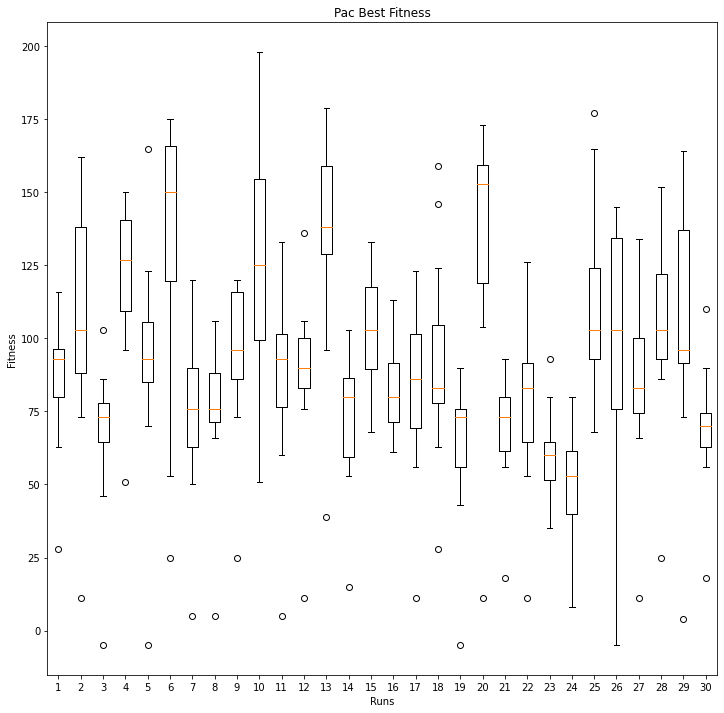

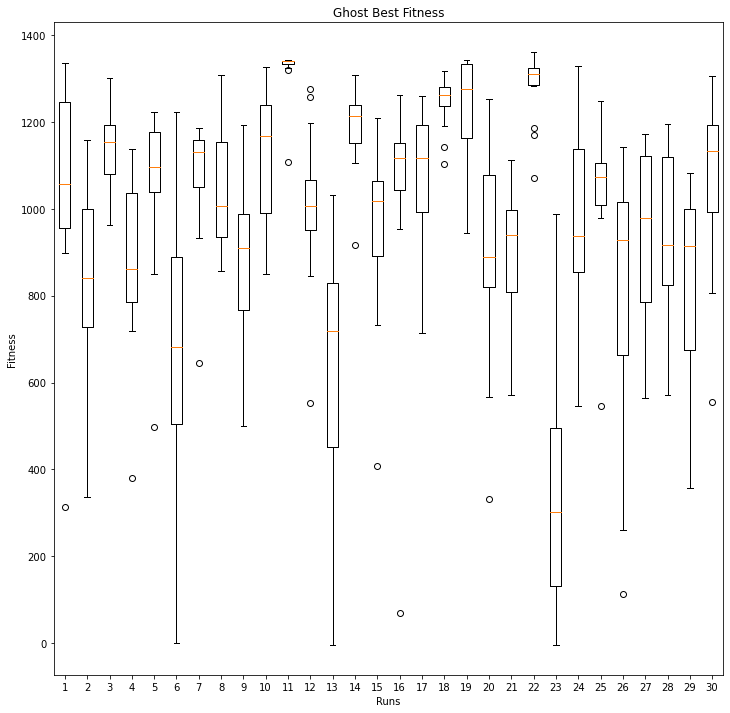

In [33]:
number_runs = 30
number_evaluations = 2000
config_filename = './configs/green2c_config.txt'

runsData = list()

# Implement your experiment here

for runCount in range(number_runs):
    print(f'Run # {runCount}')
    runsData.append(competitive_genetic_programming_search(2000, config_filename))
    
    
finalPacFitnesses = [runData[0] for runData in runsData]

highestFinalPacFitness = max(finalPacFitnesses)

finalGhostFitnesses = [runData[1] for runData in runsData]

highestFinalGhostFitness = max(finalGhostFitnesses)

finalPacIndividuals = [runData[2] for runData in runsData]

finalBestPac = finalPacIndividuals[finalPacFitnesses.index(highestFinalPacFitness)]

finalGhostIndividuals = [runData[3] for runData in runsData]

finalBestGhost = finalGhostIndividuals[finalGhostFitnesses.index(highestFinalGhostFitness)]

config = read_config(config_filename, globalVars=globals(), localVars=locals())

# playing final game with run with the highest fitness at the last generation
_, final_log = play_GPac(finalBestPac, finalBestGhost, **config['fitness_kwargs'])
    
game_log_path = 'worldFiles/greenFinalBest.txt'
with open(game_log_path, 'w') as f:
    [f.write(f'{line}\n') for line in final_log]

# logging data
runPacGenerationData = [runData[4] for runData in runsData]
runGhostGenerationData = [runData[5] for runData in runsData]


runPacFitnessStdDevs = [runData[6] for runData in runsData]
runPacFitnessAverages = [runData[7] for runData in runsData]

runGhostFitnessStdDevs = [runData[8] for runData in runsData]
runGhostFitnessAverages = [runData[9] for runData in runsData]

for runCount in range(len(runPacGenerationData)):
    with open('./data/green/pacData/run' + str(runCount) + 'Data.txt', 'w') as fp:
        for data in runPacGenerationData[runCount]:
            fp.write(f'Number of Evaluations: {data[0]}\n')
            fp.write(f'Average Fitness: {data[1]}\n')
            fp.write(f'Best Fitness: {data[2]}\n')
            fp.write('------------------------\n')
            
for runCount in range(len(runGhostGenerationData)):
    with open('./data/green/ghostData/run' + str(runCount) + 'Data.txt', 'w') as fp:
        for data in runGhostGenerationData[runCount]:
            fp.write(f'Number of Evaluations: {data[0]}\n')
            fp.write(f'Average Fitness: {data[1]}\n')
            fp.write(f'Best Fitness: {data[2]}\n')
            fp.write('------------------------\n')
            
with open('./data/green/pacData/finalRawFitnesses.txt', 'w') as fp:
    for fitness in finalPacFitnesses:
        fp.write(f'{fitness}\n')
        
with open('./data/green/ghostData/finalRawFitnesses.txt', 'w') as fp:
    for fitness in finalGhostFitnesses:
        fp.write(f'{fitness}\n')
        
with open('./data/green/pacData/stdDevFitnesses.txt', 'w') as fp:
    for fitness in runPacFitnessStdDevs:
        fp.write(f'{fitness}\n')
        
with open('./data/green/pacData/aveFitnesses.txt', 'w') as fp:
    for fitness in runPacFitnessAverages:
        fp.write(f'{fitness}\n')
        
with open('./data/green/ghostData/stdDevFitnesses.txt', 'w') as fp:
    for fitness in runGhostFitnessStdDevs:
        fp.write(f'{fitness}\n')
        
with open('./data/green/ghostData/aveFitnesses.txt', 'w') as fp:
    for fitness in runGhostFitnessAverages:
        fp.write(f'{fitness}\n')
        
with open(f'solutions/greenFinalPacTree.txt','w') as f:
    f.write(finalBestPac.print())
    
with open(f'solutions/greenFinalGhostTree.txt','w') as f:
    f.write(finalBestGhost.print())
    


# plotting data
pacBestData = [[gData[2] for gData in data] for data in runPacGenerationData]

plt.figure()
plt.title(f'Pac Best Fitness')
plt.xlabel('Runs')
plt.ylabel('Fitness')
plt.boxplot(pacBestData)

ghostBestData = [[gData[2] for gData in data] for data in runGhostGenerationData]

plt.figure()
plt.title(f'Ghost Best Fitness')
plt.xlabel('Runs')
plt.ylabel('Fitness')
plt.boxplot(ghostBestData)





## YELLOW and RED Deliverables
Feel free to create more notebook cells for YELLOW and RED deliverables as necessary. Here are some comments on those deliverables.

### Config Files
For the YELLOW and RED deliverables in this assignment, you are tasked with creating your own config files. For the YELLOW deliverable, for example, you may want to add an additional configuration parameter for how often CIAO evaluations are performed. For many of the RED deliverables, you can use the provided config files and code as inspiration for new config files and the parsing of those files, respectively.

### Modified Fitness Function
RED deliverables 2-6 require a modified version of the `play_GPac` function. See the last cell of `2b_notebook.ipynb` for more information.

### Yellow CIAO EA function

In [41]:
# implement your EA here
def competitive_CIAO_genetic_programming(number_evaluations, config_filename):
    config = read_config(config_filename, globalVars=globals(), localVars=locals())
    pac_config = {key.partition('_')[-1]:config[key] for key in config if "pac_" in key}
    ghost_config = {key.partition('_')[-1]:config[key] for key in config if "ghost_" in key}
    
    pac_generational_bests = []
    pac_ciao_values = []
    
    ghost_generational_bests = []
    ghost_ciao_values = []
    
    # full initialization of pac population
    pac_EA = GeneticProgrammingPopulation(**pac_config['EA_configs'], **pac_config, **config)
    ghost_EA = GeneticProgrammingPopulation(**ghost_config['EA_configs'], **ghost_config, **config)
    competitive_population_evaluation(pac_EA.population, ghost_EA.population, **config['fitness_kwargs'])
    
    pac_fitnesses = [individual.fitness for individual in pac_EA.population]
    best_pac = pac_EA.population[pac_fitnesses.index(max(pac_fitnesses))]
    pac_generational_bests.append(best_pac)
    
    ghost_fitnesses = [individual.fitness for individual in ghost_EA.population]
    best_ghost = ghost_EA.population[ghost_fitnesses.index(max(ghost_fitnesses))]
    ghost_generational_bests.append(best_ghost)
    
    # CIAO competitions
    pac_ciao = []
    for ghost in ghost_generational_bests:
        fitness, _ = play_GPac(best_pac, ghost)
        pac_ciao.append(fitness)
    pac_ciao_values.append(pac_ciao)
        
    ghost_ciao = []
    for pac in pac_generational_bests:
        fitness, _ = play_GPac(pac, best_ghost)
        ghost_ciao.append(fitness)
    ghost_ciao_values.append(ghost_ciao)
    
    pac_EA.evaluations = len(pac_EA.population)
    ghost_EA.evaluations = len(ghost_EA.population)
    
    total_evaluations = pac_EA.evaluations + ghost_EA.evaluations
    
    while not(total_evaluations >= number_evaluations):
        pac_children = pac_EA.generate_children()
        pac_EA.population += pac_children
        
        ghost_children = ghost_EA.generate_children()
        ghost_EA.population += ghost_children
        
        competitive_population_evaluation(pac_EA.population, ghost_EA.population, **config['fitness_kwargs'])
        
        pac_fitnesses = [individual.raw_fitness for individual in pac_EA.population]
        best_pac = pac_EA.population[pac_fitnesses.index(max(pac_fitnesses))]
        pac_generational_bests.append(best_pac)
        
        ghost_fitnesses = [individual.raw_fitness for individual in ghost_EA.population]
        best_ghost = ghost_EA.population[ghost_fitnesses.index(max(ghost_fitnesses))]
        ghost_generational_bests.append(best_ghost)
        
        # CIAO competitions
        pac_ciao = []
        for ghost in ghost_generational_bests:
            fitness, _ = play_GPac(best_pac, ghost)
            pac_ciao.append(fitness)
        pac_ciao_values.append(pac_ciao)

        ghost_ciao = []
        for pac in pac_generational_bests:
            fitness, _ = play_GPac(pac, best_ghost)
            ghost_ciao.append(fitness)
        ghost_ciao_values.append(ghost_ciao)
        
        pac_EA.evaluations += len(pac_EA.population)
        ghost_EA.evaluations += len(ghost_EA.population)
        
        total_evaluations = pac_EA.evaluations + ghost_EA.evaluations
    
    
    return pac_ciao_values, ghost_ciao_values

Function for normalizing the data

In [65]:
def normalizeData(data):
    min_value = min([min([value for value in row]) for row in data])
    for rowCount in range(len(data)):
        for valueCount in range(len(data[rowCount])):
            if min_value < 0:
                data[rowCount][valueCount] += abs(min_value)
            elif min_value > 0:
                data[rowCount][valueCount] -= min_value
    
    max_value = max([max([value for value in row]) for row in data])
    for rowCount in range(len(data)):
        for valueCount in range(len(data[rowCount])):
            data[rowCount][valueCount] /= max_value
    return data

In [66]:
# converting normal data to grayscale values
def normalToGrey(data, maxLuminance):
    for rowCount in range(len(data)):
        for valueCount in range(len(data[rowCount])):
            data[rowCount][valueCount] = int((1 - data[rowCount][valueCount]) * maxLuminance)
            
    return data

Pac Ciao Plot


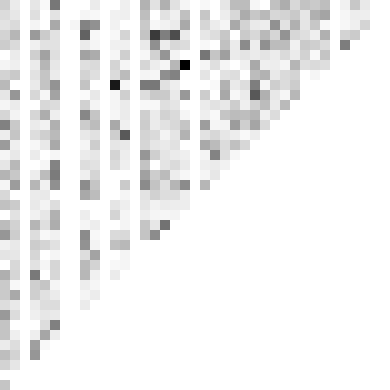

Ghost Ciao Plot


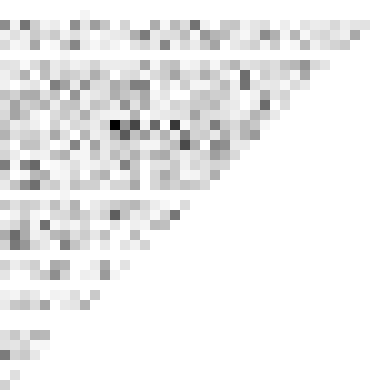

In [70]:
from PIL import Image

pac_ciao_values, ghost_ciao_values = competitive_CIAO_genetic_programming(5000, './configs/yellow2c_config.txt')

# pac ciao

normal_pac_values = normalizeData(pac_ciao_values)

pac_luminance_values = normalToGrey(normal_pac_values, 255)

num_of_gens = len(pac_ciao_values)

pac_ciao_img = Image.new('L', (num_of_gens, num_of_gens), 255)

for rowCount in range(len(pac_luminance_values)):
    for valueCount in range(len(pac_luminance_values[rowCount])):
        pac_ciao_img.putpixel(((num_of_gens-1)-rowCount, valueCount), pac_luminance_values[rowCount][valueCount])
        

pac_ciao_img_resized = pac_ciao_img.resize((num_of_gens*10, num_of_gens*10), Image.NEAREST)

pac_ciao_img_resized.save('./data/yellow/pac_ciao.png')

# ghost ciao

normal_ghost_values = normalizeData(ghost_ciao_values)

ghost_luminance_values = normalToGrey(normal_ghost_values, 255)

num_of_gens = len(ghost_ciao_values)


ghost_ciao_img = Image.new('L', (num_of_gens, num_of_gens), 255)

for rowCount in range(len(ghost_luminance_values)):
    for valueCount in range(len(ghost_luminance_values[rowCount])):
        ghost_ciao_img.putpixel(((num_of_gens-1)-rowCount, valueCount), ghost_luminance_values[rowCount][valueCount])
        

ghost_ciao_img_resized = ghost_ciao_img.resize((num_of_gens*10, num_of_gens*10), Image.NEAREST)

ghost_ciao_img_resized.save('./data/yellow/ghost_ciao.png')


print('Pac Ciao Plot')
display(pac_ciao_img_resized)

print('Ghost Ciao Plot')
display(ghost_ciao_img_resized)




### Red 2 Deliverables (Multiple Identical Pac-Man Controllers vs Multiple Identical Ghost Controllers)

Run # 0
Run # 1
Run # 2
Run # 3
Run # 4
Run # 5
Run # 6
Run # 7
Run # 8
Run # 9
Run # 10
Run # 11
Run # 12
Run # 13
Run # 14
Run # 15
Run # 16
Run # 17
Run # 18
Run # 19
Run # 20
Run # 21
Run # 22
Run # 23
Run # 24
Run # 25
Run # 26
Run # 27
Run # 28
Run # 29


{'whiskers': [<matplotlib.lines.Line2D at 0x7f7ee3f454f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7ee604df10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7ee3f45760>,
 'medians': [<matplotlib.lines.Line2D at 0x7f7ee604d880>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7ee6a5a280>,
 'means': []}

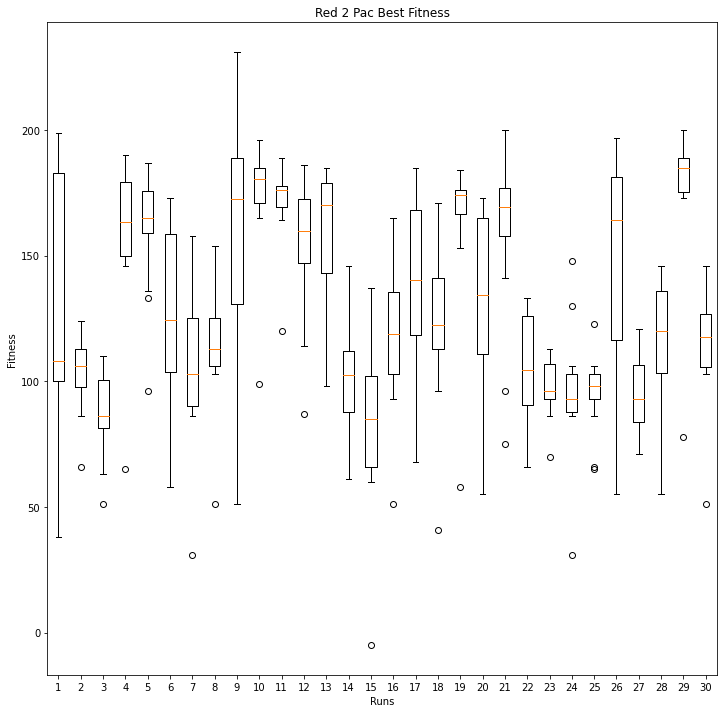

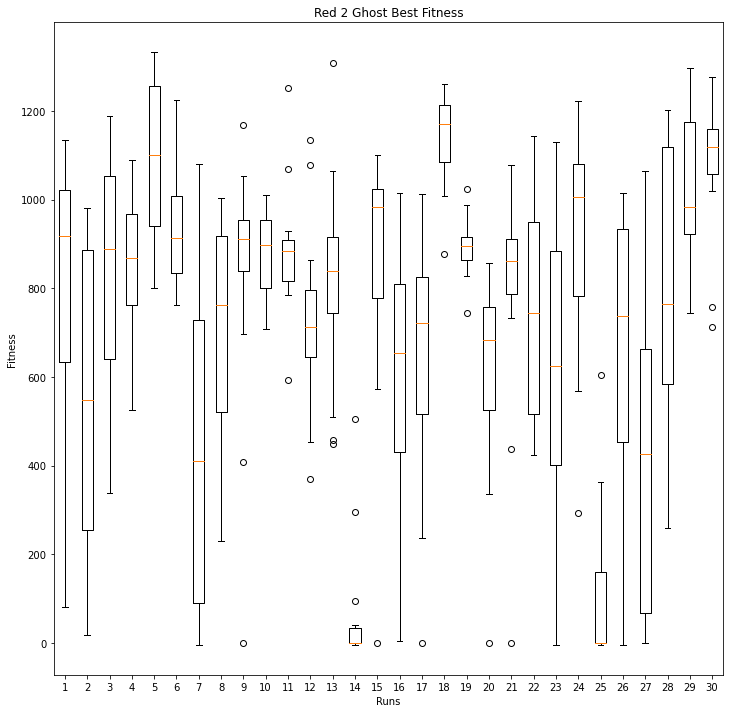

In [25]:
number_runs = 30
number_evaluations = 2000
config_filename = './configs/red2_2c_config.txt'

runsData = list()

# Implement your experiment here

for runCount in range(number_runs):
    print(f'Run # {runCount}')
    runsData.append(competitive_genetic_programming_search(2000, config_filename))
    
    
finalPacFitnesses = [runData[0] for runData in runsData]

highestFinalPacFitness = max(finalPacFitnesses)

finalGhostFitnesses = [runData[1] for runData in runsData]

highestFinalGhostFitness = max(finalGhostFitnesses)

finalPacIndividuals = [runData[2] for runData in runsData]

finalBestPac = finalPacIndividuals[finalPacFitnesses.index(highestFinalPacFitness)]

finalGhostIndividuals = [runData[3] for runData in runsData]

finalBestGhost = finalGhostIndividuals[finalGhostFitnesses.index(highestFinalGhostFitness)]

config = read_config(config_filename, globalVars=globals(), localVars=locals())

# playing final game with run with the highest fitness at the last generation
_, final_log = play_GPac(finalBestPac, finalBestGhost, **config['fitness_kwargs'])
    
game_log_path = 'worldFiles/red2FinalBest.txt'
with open(game_log_path, 'w') as f:
    [f.write(f'{line}\n') for line in final_log]

# logging data
runPacGenerationData = [runData[4] for runData in runsData]
runGhostGenerationData = [runData[5] for runData in runsData]


runPacFitnessStdDevs = [runData[6] for runData in runsData]
runPacFitnessAverages = [runData[7] for runData in runsData]

runGhostFitnessStdDevs = [runData[8] for runData in runsData]
runGhostFitnessAverages = [runData[9] for runData in runsData]

for runCount in range(len(runPacGenerationData)):
    with open('./data/red2/pacData/run' + str(runCount) + 'Data.txt', 'w') as fp:
        for data in runPacGenerationData[runCount]:
            fp.write(f'Number of Evaluations: {data[0]}\n')
            fp.write(f'Average Fitness: {data[1]}\n')
            fp.write(f'Best Fitness: {data[2]}\n')
            fp.write('------------------------\n')
            
for runCount in range(len(runGhostGenerationData)):
    with open('./data/red2/ghostData/run' + str(runCount) + 'Data.txt', 'w') as fp:
        for data in runGhostGenerationData[runCount]:
            fp.write(f'Number of Evaluations: {data[0]}\n')
            fp.write(f'Average Fitness: {data[1]}\n')
            fp.write(f'Best Fitness: {data[2]}\n')
            fp.write('------------------------\n')
            
with open('./data/red2/pacData/finalRawFitnesses.txt', 'w') as fp:
    for fitness in finalPacFitnesses:
        fp.write(f'{fitness}\n')
        
with open('./data/red2/ghostData/finalRawFitnesses.txt', 'w') as fp:
    for fitness in finalGhostFitnesses:
        fp.write(f'{fitness}\n')
        
with open('./data/red2/pacData/stdDevFitnesses.txt', 'w') as fp:
    for fitness in runPacFitnessStdDevs:
        fp.write(f'{fitness}\n')
        
with open('./data/red2/pacData/aveFitnesses.txt', 'w') as fp:
    for fitness in runPacFitnessAverages:
        fp.write(f'{fitness}\n')
        
with open('./data/red2/ghostData/stdDevFitnesses.txt', 'w') as fp:
    for fitness in runGhostFitnessStdDevs:
        fp.write(f'{fitness}\n')
        
with open('./data/red2/ghostData/aveFitnesses.txt', 'w') as fp:
    for fitness in runGhostFitnessAverages:
        fp.write(f'{fitness}\n')
        
with open(f'solutions/red2FinalPacTree.txt','w') as f:
    f.write(finalBestPac.print())
    
with open(f'solutions/red2FinalGhostTree.txt','w') as f:
    f.write(finalBestGhost.print())
    


# plotting data
pacBestData = [[gData[2] for gData in data] for data in runPacGenerationData]

plt.figure()
plt.title('Red 2 Pac Best Fitness')
plt.xlabel('Runs')
plt.ylabel('Fitness')
plt.boxplot(pacBestData)

ghostBestData = [[gData[2] for gData in data] for data in runGhostGenerationData]

plt.figure()
plt.title('Red 2 Ghost Best Fitness')
plt.xlabel('Runs')
plt.ylabel('Fitness')
plt.boxplot(ghostBestData)

